In [13]:
import pandas as pd
import json
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style for professional-looking graphs
sns.set_theme(style="whitegrid")
pd.set_option('display.width', 200)

In [14]:
def load_and_process_results(results_dir: Path) -> pd.DataFrame:
    """
    Loads all .jsonl files from the results directory, parses them,
    and returns a clean pandas DataFrame.
    """
    all_results = []
    for file_path in results_dir.glob("*.jsonl"):
        with open(file_path, "r") as f:
            for line in f:
                if line.strip():
                    data = json.loads(line)
                    # Flatten the nested JSON into a single dictionary
                    flat_data = {
                        "case_name": data["case_name"],
                        "backend": data["backend"],
                        "timestamp_utc": data["timestamp_utc"],
                        "price": data["outputs"]["price"],
                        "time_ms": data["outputs"]["time_ms"],
                        **data["inputs"] # Unpack all input parameters
                    }
                    if flat_data["price"] > 8.0 and flat_data["price"] < 9.0: ###### not including garbage results from bad/bugged runs -- the price 100% has to be between 8.0 and 9.0 
                        all_results.append(flat_data) ########
    
    if not all_results:
        return pd.DataFrame()
        
    df = pd.DataFrame(all_results)
    
    # Convert data types for better analysis
    df["timestamp_utc"] = pd.to_datetime(df["timestamp_utc"])
    df["time_s"] = df["time_ms"] / 1000.0 # Add a column for time in seconds
    
    # Sort the data for consistent plotting
    df = df.sort_values(by=["case_name", "timestamp_utc"])
    backend_name_map = {
    "py": "Python (NumPy)",
    "numba": "Numba (JIT)",
    "cpp": "C++ (Scalar)",
    "cpp_arena": "C++ (Scalar + Arena)",
    "cpp_simd": "C++ (SIMD)",
    "cpp_mp": "C++ (MP + Arena)",
    "cpp_ultimate": "C++ (MP + SIMD + Arena)"
    }
    df['backend_desc'] = df['backend'].map(backend_name_map)
    
    return df

# Assuming the notebook is in the 'analysis' folder, the root is the parent.
PROJECT_ROOT = Path().resolve().parent
RESULTS_DIR = PROJECT_ROOT / "RESULTS"

df = load_and_process_results(RESULTS_DIR)

# Display the head of the loaded data to verify
df.head()

,case_name,backend,timestamp_utc,price,time_ms,S0,K,T,r,sigma,num_paths,num_steps,seed,time_s,backend_desc
20,bs_american_put_large,numba,2025-09-06 12:00:37.725119,8.716144,9435.8798,100.0,105.0,1.0,0.05,0.2,102400,100,42,9.435880,Numba (JIT)
21,bs_american_put_large,cpp,2025-09-06 12:00:45.035592,8.691083,7302.6054,100.0,105.0,1.0,0.05,0.2,102400,100,42,7.302605,C++ (Scalar)
28,bs_american_put_large,numba,2025-09-10 23:55:50.955184,8.716144,6600.5931,100.0,105.0,1.0,0.05,0.2,102400,100,42,6.600593,Numba (JIT)
29,bs_american_put_large,cpp,2025-09-10 23:55:56.433171,8.691083,5476.6013,100.0,105.0,1.0,0.05,0.2,102400,100,42,5.476601,C++ (Scalar)
36,bs_american_put_large,numba,2025-09-11 00:08:33.976953,8.716144,6966.7104,100.0,105.0,1.0,0.05,0.2,102400,100,42,6.966710,Numba (JIT)


In [15]:
# Focus on the 'large' case for our primary performance comparison
df_large = df[df['case_name'] == 'bs_american_put_large'].copy()

# Calculate speedup relative to the scalar C++ backend
baseline_time = df_large[df_large['backend'] == 'cpp']['time_s'].median()
if pd.isna(baseline_time) or baseline_time == 0:
    # Handle case where 'cpp' backend might not be in the 'large' case
    baseline_time = df_large[df_large['backend_desc'] == 'C++ (Scalar)']['time_s'].median()

df_large['speedup_vs_cpp'] = baseline_time / df_large['time_s']

summary_table = df_large.pivot_table(
    index="backend_desc", # <-- USE THE NEW COLUMN
    values=["time_s", "price", "speedup_vs_cpp"],
    aggfunc={"time_s": "median", "price": "mean", "speedup_vs_cpp": "median"}
).sort_values(by="time_s")

print("--- Performance Summary for 'Large' Workload ---")
print(summary_table)

--- Performance Summary for 'Large' Workload ---
                            price  speedup_vs_cpp    time_s
backend_desc                                               
C++ (MP + Arena)         8.704372        1.819108  4.202030
C++ (MP + SIMD + Arena)  8.688792        1.540055  4.964067
C++ (Scalar + Arena)     8.691083        1.516128  5.041755
C++ (SIMD)               8.711844        1.347272  5.691236
Numba (JIT)              8.716144        1.012328  7.550863
C++ (Scalar)             8.691083        1.001998  7.643947


C:\Users\kedar\AppData\Local\Temp\ipykernel_13456\1054700702.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


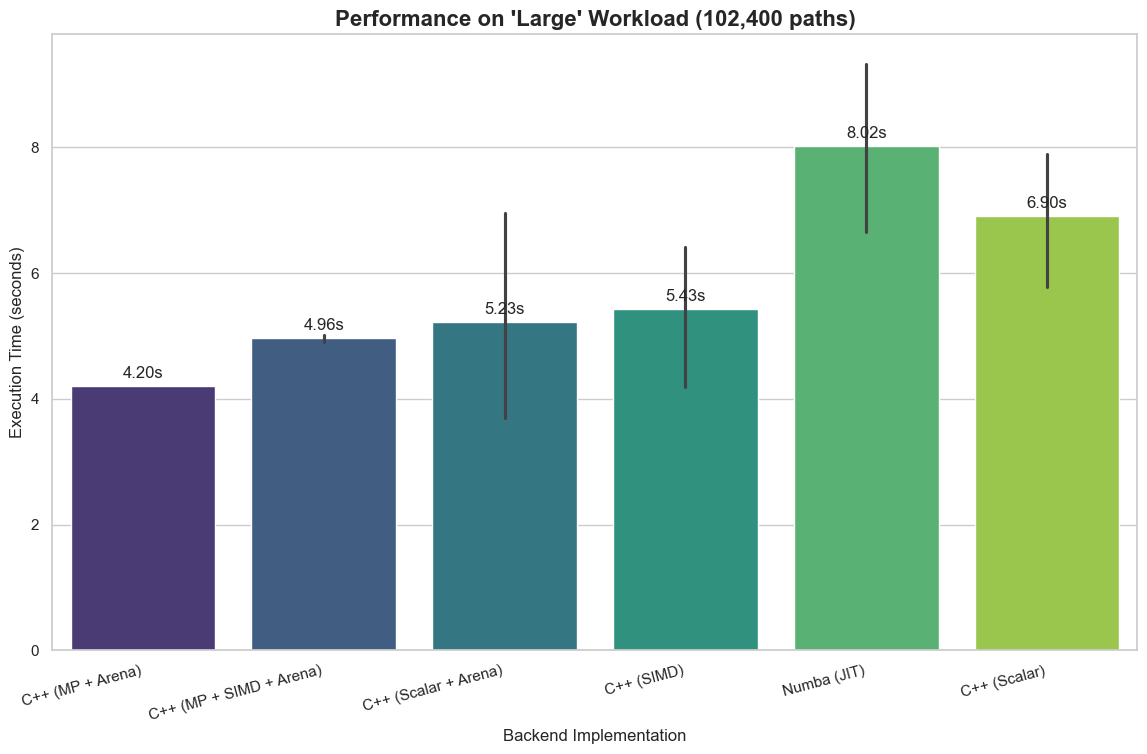

In [16]:
# Order the backends by performance for a clearer chart
order = summary_table.index

plt.figure(figsize=(14, 8)) # Make the figure a bit wider for longer names
ax = sns.barplot(
    data=df_large,
    x="backend_desc", # <-- USE THE NEW COLUMN
    y="time_s",
    order=order,
    palette="viridis"
)

ax.set_title("Performance on 'Large' Workload (102,400 paths)", fontsize=16, weight='bold')
ax.set_xlabel("Backend Implementation", fontsize=12) # More descriptive label
ax.set_ylabel("Execution Time (seconds)", fontsize=12)
plt.xticks(rotation=15, ha='right') # Rotate labels slightly for readability

# Add text labels on top of each bar
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}s",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')

# Save the figure to a file
output_path = PROJECT_ROOT / "analysis" / "performance_large_workload.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')

plt.show()

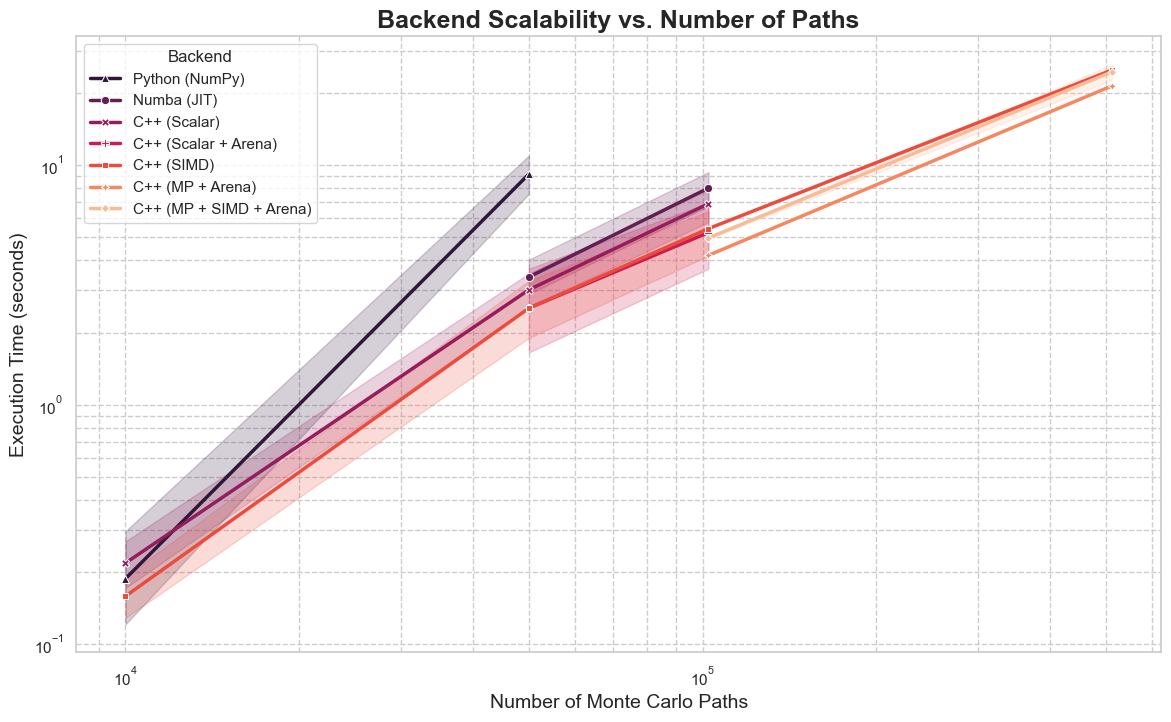

In [17]:
# Cell 5 (DEFINITIVELY CORRECTED)

# We need to filter out the Numba JIT compile time for a fair plot
df_filtered = df[~((df['case_name'] == 'bs_american_put_small') & (df['backend'] == 'numba'))]

# --- Self-contained definitions for plotting ---
# This dictionary must be in the same cell to avoid NameErrors
backend_name_map = {
    "py": "Python (NumPy)",
    "numba": "Numba (JIT)",
    "cpp": "C++ (Scalar)",
    "cpp_arena": "C++ (Scalar + Arena)",
    "cpp_simd": "C++ (SIMD)",
    "cpp_mp": "C++ (MP + Arena)",
    "cpp_ultimate": "C++ (MP + SIMD + Arena)"
}

# Define a consistent order for the backends
backend_order = ['py', 'numba', 'cpp', 'cpp_arena', 'cpp_simd', 'cpp_mp', 'cpp_ultimate']

# Create the ordered list of descriptive names for the plot legend
backend_desc_order = [backend_name_map[b] for b in backend_order if b in df['backend'].unique()]
palette = sns.color_palette("rocket", n_colors=len(backend_desc_order))
# --- End of definitions ---

plt.figure(figsize=(14, 8))
ax = sns.lineplot(
    data=df_filtered,
    x="num_paths",
    y="time_s",
    hue="backend_desc",
    hue_order=backend_desc_order,
    palette=palette,
    style="backend_desc",
    markers=True,
    dashes=False,
    lw=2.5
)

ax.set_title("Backend Scalability vs. Number of Paths", fontsize=18, weight='bold')
ax.set_xlabel("Number of Monte Carlo Paths", fontsize=14)
ax.set_ylabel("Execution Time (seconds)", fontsize=14)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(title='Backend', fontsize=11)
plt.grid(True, which="both", ls="--")

# Save the figure
output_path_scaling = PROJECT_ROOT / "analysis" / "backend_scalability.png"
plt.savefig(output_path_scaling, dpi=300, bbox_inches='tight')

plt.show()